In [41]:
from __future__ import absolute_import

%matplotlib inline 
import numpy as np
import pylab
import os
from keras.layers import Layer, InputSpec
import matplotlib.pyplot as plt
import sys
import pandas as pd
import collections 
import keras
import seaborn as sns
import keras.backend.tensorflow_backend as K
from keras.layers import Input, LSTM, Dropout, Conv1D
from keras.models import Model,Sequential
from keras.layers.core import Dense, Lambda, Activation, Flatten
from keras import objectives
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import History
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping 
from sklearn.preprocessing import MinMaxScaler
from google.cloud import bigquery   # pip install google-cloud-bigquery
K.set_session
plt.style.use('ggplot')
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]='/Users/tatsuyahagiwara/d/BUYMA/bigquery.json'

In [42]:
client = bigquery.Client(project='neon-opus-132123')
job_config = bigquery.QueryJobConfig()
job_config.use_legacy_sql = False

In [43]:
query =  """
#standardSQL
with category_tree as(
SELECT
c.cate_id
,c.topcate_id
FROM `info_db.m_category` c
)
select mk.kaiin_id,
format_timestamp("%Y%m%d%H", sa.time) AS hours, sa.gender, sa.device,
category_tree.topcate_id label
FROM `search_logs.search_log*` sa
JOIN `info_db.d_torihiki` dt ON sa.kaiin_id=CAST(dt.konyu_id as string)
JOIN `info_db.m_syohin` ms ON dt.syo_id = ms.syo_id
JOIN `info_db.m_kaiin` mk on dt.konyu_id = mk.kaiin_id
INNER JOIN category_tree on category_tree.cate_id=ms.cate_id
where dt.insdate >= '2018-06-29' and dt.insdate < '2018-07-01'
  """

In [44]:
query_job = client.query(query, job_config=job_config)
results = query_job.result()

In [45]:
csv=[[i.kaiin_id, i.hours, i.device, i.label] for i in list(results)]

In [ ]:
# mke Dataframe
csv=pd.DataFrame(csv)
listed=['kaiin_id', 'hours', 'device', 'label']
csv.columns = listed
csv=csv.drop('kaiin_id', axis=1)
# csv.to_csv('time.csv')　  

In [70]:
# label
csv=pd.read_csv('time.csv')
csv=csv.drop('Unnamed: 0', axis=1)
print(list(collections.Counter(csv['label']).keys()))
csv.head()

[1004, 1001, 1005, 1002, 1003, 1006]


,hours,gender,device,label
0,2018072102,Male,PC,1004
1,2018072102,Male,PC,1004
2,2018072102,Male,PC,1004
3,2018072102,Male,PC,1004
4,2018072102,Male,PC,1004


In [71]:
# number of platform
plat = csv.device.value_counts()

print(plat)
print('\nUnique values of platform:', csv.device.unique())

SmartPhone           4736090
BUYMA-IPHONE-APP     2366924
PC                   1822858
Tablet                491248
Buyma-Android-App     100108
Name: device, dtype: int64

Unique values of platform: ['PC' 'Tablet' 'SmartPhone' 'BUYMA-IPHONE-APP' 'Buyma-Android-App']


Text(0, 0.5, 'Occurence count')

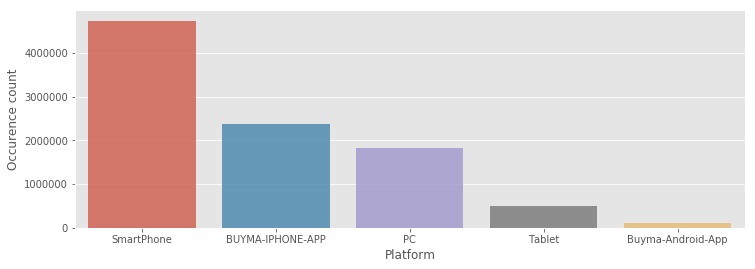

In [72]:
# platform histgram
csv.device = csv.device.astype(str)
plat = csv.device.value_counts()

plt.figure(figsize=(12,4))
sns.barplot(plat.index, plat.values, alpha=0.8)
plt.xlabel('Platform', fontsize=12)
plt.ylabel('Occurence count', fontsize=12)

In [73]:
hour=[str(i)[8:] for i in csv.hours]
hour=[int(i) for i in hour]

day=[str(i)[6:8] for i in csv.hours]
day=[int(i) for i in day]

In [74]:
# time
data_size=100000
hour=hour[:data_size]
day=day[:data_size]
df=csv[:data_size]
df["hour"] = [i for i in hour]
df["day"] =[i%24 for i in day]

/anaconda3/envs/django/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/envs/django/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [75]:
df.head()

,hours,gender,device,label,hour,day
0,2018072102,Male,PC,1004,2,21
1,2018072102,Male,PC,1004,2,21
2,2018072102,Male,PC,1004,2,21
3,2018072102,Male,PC,1004,2,21
4,2018072102,Male,PC,1004,2,21


Text(0, 0.5, 'Fraction of Events')

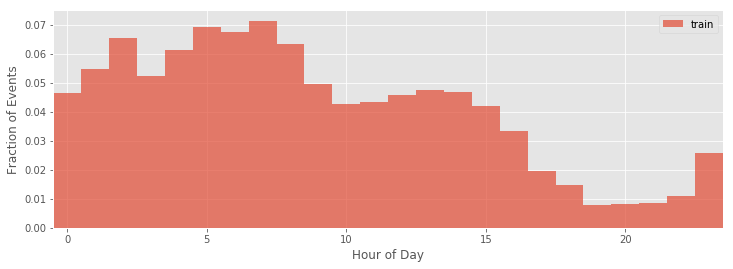

In [76]:
# time histgram
plt.figure(figsize=(12,4))
df.hour.hist(bins=np.linspace(-0.5, 23.5, 25), label="train", alpha=0.7, normed=True)
plt.xlim(-0.5, 23.5)
plt.legend(loc="best")
plt.xlabel("Hour of Day")
plt.ylabel("Fraction of Events")

Text(0, 0.5, 'Days')

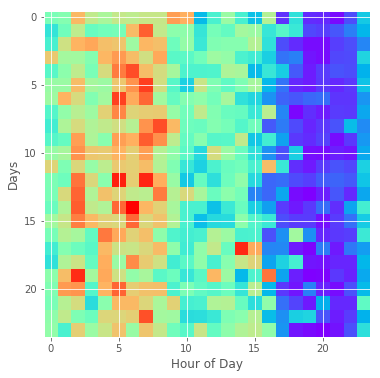

In [77]:
# heat map
plt.figure(figsize=(12,6))
hour_day_counts = df.groupby(["hour", "day"]).count().device.values.reshape(24,-1)
# plot 2d hist in days and hours, with each day normalised to 1 
plt.imshow((hour_day_counts / hour_day_counts.sum(axis=0)).T,
           interpolation="none", cmap="rainbow")
plt.xlabel("Hour of Day")
plt.ylabel("Days")